In [1]:
# ======================================================================
# 📌 PREDICCIÓN DE DOGE-USD CON RNN, LSTM Y GRU
# ======================================================================

import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU
from tensorflow.keras.optimizers import Adam

In [17]:
# ----------------------------------------------------------------------
# 1. HIPERPARÁMETROS (MODIFICABLES)
# ----------------------------------------------------------------------
N_NEURONAS   = 64       # número de neuronas por capa recurrente
EPOCHS       = 50      # número de épocas
BATCH_SIZE   = 8        # tamaño del batch
LOOKBACK     = 30       # días de historial para predecir
LR           = 0.001    # learning rate
DIAS_PRED    = 6        # días a predecir

In [18]:
# ----------------------------------------------------------------------
# 2. DESCARGA Y PREPROCESADO DE DATOS
# ----------------------------------------------------------------------
df = yf.download("DOGE-USD", start="2020-01-01", end="2024-12-31")
df = df[["Close"]].dropna()

# Normalización
scaler = MinMaxScaler()
datos = scaler.fit_transform(df)

# Construcción de secuencias
X, y = [], []
for i in range(LOOKBACK, len(datos)):
    X.append(datos[i-LOOKBACK:i, 0])
    y.append(datos[i, 0])
X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # (muestras, timesteps, features)

# División en entrenamiento y validación
X_train, X_val = X[:-DIAS_PRED], X[-DIAS_PRED:]
y_train, y_val = y[:-DIAS_PRED], y[-DIAS_PRED:]

C:\Users\ACER\AppData\Local\Temp\ipykernel_17552\2147396478.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("DOGE-USD", start="2020-01-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed


In [19]:
# ----------------------------------------------------------------------
# 3. FUNCIÓN PARA ENTRENAR Y PREDECIR CON CADA MODELO
# ----------------------------------------------------------------------
def entrenar_y_predecir(tipo_modelo, X_train, y_train, X_val, y_val):
    model = Sequential()

    if tipo_modelo == "RNN":
        model.add(SimpleRNN(N_NEURONAS, activation="tanh", input_shape=(LOOKBACK,1)))
    elif tipo_modelo == "LSTM":
        model.add(LSTM(N_NEURONAS, activation="tanh", input_shape=(LOOKBACK,1)))
    elif tipo_modelo == "GRU":
        model.add(GRU(N_NEURONAS, activation="tanh", input_shape=(LOOKBACK,1)))

    model.add(Dense(1))  

    opt = Adam(learning_rate=LR)
    model.compile(optimizer=opt, loss="mse")

    # Entrenamiento
    model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
              validation_data=(X_val,y_val), verbose=0)

    # Predicción futura (2025-01-01 → 2025-01-06)
    ultimos_dias = datos[-LOOKBACK:]   
    predicciones = []
    entrada = ultimos_dias.reshape(1, LOOKBACK, 1)

    for _ in range(DIAS_PRED):
        pred = model.predict(entrada, verbose=0)  # (1,1)
        predicciones.append(pred[0,0])
        pred_reshaped = np.reshape(pred, (1,1,1))
        entrada = np.concatenate((entrada[:,1:,:], pred_reshaped), axis=1)

    predicciones = scaler.inverse_transform(np.array(predicciones).reshape(-1,1))
    return predicciones

In [20]:
# ----------------------------------------------------------------------
# 4. EVALUACIÓN DE CADA MODELO
# ----------------------------------------------------------------------
df_future = yf.download("DOGE-USD", start="2020-01-01", end="2024-12-31")
reales = df_future["Close"].values.reshape(-1,1)

resultados = []

for modelo in ["RNN", "LSTM", "GRU"]:
    pred = entrenar_y_predecir(modelo, X_train, y_train, X_val, y_val)

    n = min(len(pred), len(reales))
    pred, reales_cmp = pred[:n], reales[:n]

    mae = mean_absolute_error(reales_cmp, pred)
    mse = mean_squared_error(reales_cmp, pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((reales_cmp - pred) / reales_cmp)) * 100

    resultados.append({
        "Modelo": modelo,
        "MAE": mae,
        "RMSE": rmse,
        "MAPE": mape,
        "Predicciones": pred
    })

C:\Users\ACER\AppData\Local\Temp\ipykernel_17552\3044997881.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_future = yf.download("DOGE-USD", start="2020-01-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed
c:\Users\ACER\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\ACER\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\ACER\AppData\Local\Programs\Python\Python313\Lib\site-packages\ker

In [22]:
# ----------------------------------------------------------------------
# 5. SELECCIÓN DEL MEJOR MODELO
# ----------------------------------------------------------------------
df_resultados = pd.DataFrame([{k:v for k,v in r.items() if k!="Predicciones"} for r in resultados])
mejor_modelo = df_resultados.loc[df_resultados["MAPE"].idxmin()]

print("\n📊 RESULTADOS POR MODELO")
print("="*60)
print(df_resultados)

print("\n✅ MEJOR MODELO SELECCIONADO:", mejor_modelo["Modelo"])
print(f"MAPE: {mejor_modelo['MAPE']:.2f}%")

if mejor_modelo["MAPE"] >= 4:
    print("\n⚠️ ALERTA: El MAPE está por encima del 4%. Ajusta hiperparámetros.")


📊 RESULTADOS POR MODELO
  Modelo       MAE      RMSE          MAPE
0    RNN  0.311951  0.311953  14152.874904
1   LSTM  0.283477  0.283903  12911.700509
2    GRU  0.300267  0.300367  13646.437079

✅ MEJOR MODELO SELECCIONADO: LSTM
MAPE: 12911.70%

⚠️ ALERTA: El MAPE está por encima del 4%. Ajusta hiperparámetros.


In [8]:
# ----------------------------------------------------------------------
# 6. TABLA COMPARATIVA DEL MEJOR MODELO
# ----------------------------------------------------------------------
pred_final = resultados[df_resultados["MAPE"].idxmin()]["Predicciones"]

n = min(len(pred_final), len(reales))
tabla = pd.DataFrame({
    "Fecha": df_future.index[:n],
    "Real": reales[:n].flatten(),
    "Predicción": pred_final[:n].flatten()
})

print("\n🔮 PREDICCIÓN VS REAL (MEJOR MODELO)")
print("="*60)
print(tabla)



🔮 PREDICCIÓN VS REAL (MEJOR MODELO)
       Fecha      Real  Predicción
0 2025-01-01  0.324306    0.305037
1 2025-01-02  0.338610    0.297569
2 2025-01-03  0.379279    0.290790
3 2025-01-04  0.394746    0.284027
4 2025-01-05  0.382563    0.277591
5 2025-01-06  0.387957    0.271281


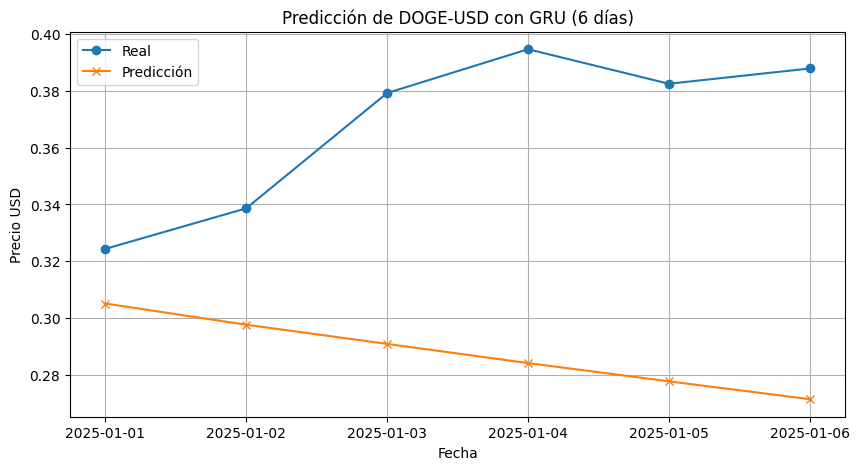

In [9]:
# ----------------------------------------------------------------------
# 7. GRAFICAR RESULTADOS
# ----------------------------------------------------------------------
plt.figure(figsize=(10,5))
plt.plot(tabla["Fecha"], tabla["Real"], marker="o", label="Real")
plt.plot(tabla["Fecha"], tabla["Predicción"], marker="x", label="Predicción")
plt.title(f"Predicción de DOGE-USD con {mejor_modelo['Modelo']} ({DIAS_PRED} días)")
plt.xlabel("Fecha")
plt.ylabel("Precio USD")
plt.legend()
plt.grid(True)
plt.show()